# Analyzing the dataset

In [1]:
from collections import Counter
from copy import deepcopy
from itertools import chain
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from statistics import mean, variance
from wordcloud import WordCloud

import contractions
import matplotlib.pyplot as plt
import pandas
import re
import string

In [2]:
stop_words = set(stopwords.words("english"))

## Getting the Data

In [3]:
data = pandas.read_csv("../data/sarcasm-dataset.csv", index_col=False)

In [4]:
display(data)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [5]:
print("Data was collected from %d users and %d subreddits." % (data["author"].nunique(), data["subreddit"].nunique()))

Data was collected from 256561 users and 14878 subreddits.


### Drop the columns we will not work on

In [6]:
data.drop(columns=["author", "subreddit", "score", "ups", "downs", "date", "created_utc"], inplace=True)

In [7]:
data.dtypes

label              int64
comment           object
parent_comment    object
dtype: object

## Clean text from stopwords and punctuations

In [8]:
def expand_contractions(text):
    return contractions.fix(str(text))

def clean_text(text):
    tokens = word_tokenize(str(text))

    # Lowercase, replace "!" and "?", remove stop words, remove remaining punctuation
    for idx in range(len(tokens)):
        token = tokens[idx].lower()
        if token == "!":
            token = ' EXM '
        elif token == "?":
            token = ' QEM '
        tokens[idx] = token
        
    filtered_text = " ".join([token for token in tokens if token not in stop_words])
    filtered_text = re.sub(r'[^\w\s]', '', filtered_text)
    
    # Drop row if the comment is empty after cleaning
    if filtered_text.strip() == "":
        return None

    return filtered_text

In [9]:
data['comment'] = data['comment'].apply(expand_contractions)
data['comment'] = data['comment'].apply(clean_text)
print("[COMMENTS CLEANED]")

data['parent_comment'] = data['parent_comment'].apply(expand_contractions)
data['parent_comment'] = data['parent_comment'].apply(clean_text)
print("[PARENT COMMENTS CLEANED]")


data = data.dropna(subset=['label'])
data = data.dropna(subset=['comment'])
data = data.dropna(subset=['parent_comment'])

data = data.reset_index(drop=True)

[COMMENTS CLEANED]
[PARENT COMMENTS CLEANED]


In [10]:
display(data)

,label,comment,parent_comment
0,0,nc nh,yeah get argument point would prefer lived ...
1,0,know west teams play west teams east teams rig...,blazers mavericks wests 5 6 seed even carry ...
2,0,underdogs earlier today since gronk s announc...,favored win
3,0,meme funny none new york nigga ones,deadass kill buzz
4,0,could use one tools,yep confirm saw tool use made boy easports_mut
...,...,...,...
1002471,1,sure iran n korea technology create pigbirdhum...,one calling engineered pathogen reports virus...
1002472,1,whatever vote green EXM,move typical recent donothing approach co2 emi...
1002473,1,perhaps atheist conspiracy make christians loo...,screw disabled got get church time
1002474,1,slavs got country called kosovo,always unsettled hear lot jewish people say i...


## Stats

In [11]:
data["label"].value_counts()

1    503228
0    499248
Name: label, dtype: int64

In [12]:
comments = [txt for txt in data['comment']]
parent_comments = [txt for txt in data['parent_comment']]
labels = list(data["label"])

In [13]:
comment_lengths = [len(text) for text in comments]
parent_lengths = [len(text) for text in parent_comments]

print("PARENT COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(parent_lengths), variance(parent_lengths)))
print("COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(comment_lengths), variance(comment_lengths)))

PARENT COMMENTS: [Average length: 89.98] [Variance: 24940.30]
COMMENTS: [Average length: 37.98] [Variance: 2607.84]


In [14]:
sarc_comments = [comment for idx, comment in enumerate(comments) if labels[idx]==1]
nsarc_comments = [comment for idx, comment in enumerate(comments) if labels[idx]==0]

print("'%s' is sarcastic." % sarc_comments[200])
print("'%s' is NOT sarcastic." % nsarc_comments[200])

'one trump supporter' is sarcastic.
'think misspelled  speed ' is NOT sarcastic.


In [15]:
sarc_lengths = [len(text) for text in sarc_comments]
nsarc_lengths = [len(text) for text in nsarc_comments]

print("SARCASTIC COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(sarc_lengths), variance(sarc_lengths)))
print("NON-SARCASTIC COMMENTS: [Average length: %.2f] [Variance: %.2f]" % (mean(nsarc_lengths), variance(nsarc_lengths)))

SARCASTIC COMMENTS: [Average length: 37.72] [Variance: 691.57]
NON-SARCASTIC COMMENTS: [Average length: 38.23] [Variance: 4539.27]


## Top words

In [16]:
sarc_comments = [text.split() for text in sarc_comments]
nsarc_comments = [text.split() for text in nsarc_comments]

sarc_comments = list(chain.from_iterable(sarc_comments))
nsarc_comments = list(chain.from_iterable(nsarc_comments))

In [17]:
print("Most popular in sarcastic:")
print([x[0] for x in Counter(sarc_comments).most_common(20)])
print("Most popular in non-sarcastic: ")
print([x[0] for x in Counter(nsarc_comments).most_common(20)])

Most popular in sarcastic:
['EXM', 'QEM', 'yeah', 'like', 'would', 'people', 'well', 'get', 'know', 'right', 's', 'one', 'good', 'sure', 'yes', 'us', 'think', 'oh', 'make', 'really']
Most popular in non-sarcastic: 
['QEM', 'would', 'like', 'EXM', 'one', 'get', 'people', 'think', 's', 'know', 'well', 'good', 'fuck', 'really', 'time', 'going', 'could', 'yeah', 'even', 'still']


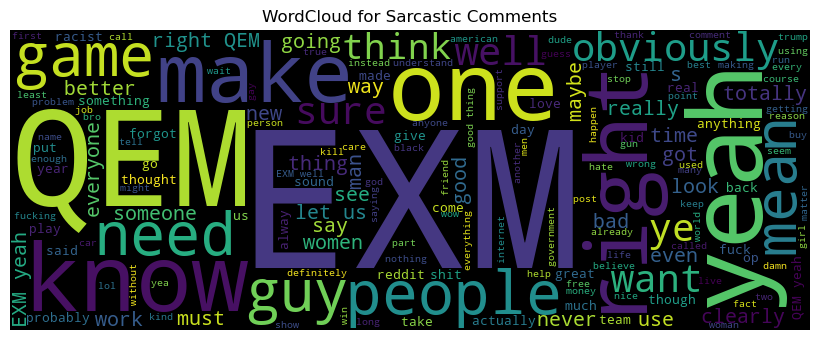

In [18]:
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='black',
                min_font_size = 10).generate(" ".join([w for w in sarc_comments]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Sarcastic Comments")
plt.tight_layout(pad = 0)
 
plt.show()

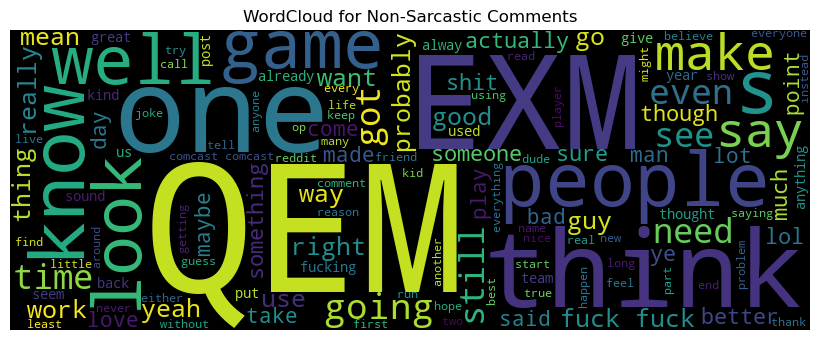

In [19]:
wordcloud = WordCloud(width = 800, height = 300,
                background_color ='black',
                min_font_size = 10).generate(" ".join([w for w in nsarc_comments]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Non-Sarcastic Comments")
plt.tight_layout(pad = 0)
 
plt.show()